In [57]:
# 범주형 데이터를 그대로 적용하여 학습 + randomized_search(cb 자체)

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier , Pool
from scipy.stats import randint, uniform
from sklearn.metrics import classification_report, roc_auc_score, f1_score, roc_curve, auc

In [59]:
df = pd.read_csv('../data/okcupid_preprocessed_ENCODING_X.csv')

In [60]:
df["last_online_dt"] = pd.to_datetime(df["last_online"])
ref_date = df["last_online_dt"].max() # 마지막 관측 시간

# churn 정의
THRESHOLD_DAYS = 30
df["inactive_days"] = (ref_date - df["last_online_dt"]).dt.days
df["churn"] = (df["inactive_days"] >= THRESHOLD_DAYS).astype(int)

print("ref_date:", ref_date)
print("churn rate:", df["churn"].mean())

ref_date: 2012-07-01 00:00:00
churn rate: 0.259235158674542


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59934 entries, 0 to 59933
Data columns (total 30 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Unnamed: 0       59934 non-null  int64         
 1   sex              59934 non-null  int64         
 2   orientation      59934 non-null  int64         
 3   body_type        59934 non-null  object        
 4   drinks           59934 non-null  object        
 5   drugs            59934 non-null  int64         
 6   education        53310 non-null  float64       
 7   height           59934 non-null  float64       
 8   job              59934 non-null  object        
 9   last_online      59934 non-null  object        
 10  religion         59934 non-null  object        
 11  sign             59934 non-null  int64         
 12  smokes           59934 non-null  object        
 13  age              59934 non-null  int64         
 14  status           59934 non-null  objec

In [62]:
# X 데이터 정리
drop_cols = [
    "Unnamed: 0", "job", "last_online", "last_online_dt", "inactive_days", "churn",
    "status", "location", "pets", "city", "location_group", "sign"
]

drop_list = []

for col in drop_cols:
    if col in df.columns:
        drop_list.append(col)

X = df.drop(columns=drop_list)

# 라벨 데이터
y = df["churn"]

In [63]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59934 entries, 0 to 59933
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sex              59934 non-null  int64  
 1   orientation      59934 non-null  int64  
 2   body_type        59934 non-null  object 
 3   drinks           59934 non-null  object 
 4   drugs            59934 non-null  int64  
 5   education        53310 non-null  float64
 6   height           59934 non-null  float64
 7   religion         59934 non-null  object 
 8   smokes           59934 non-null  object 
 9   age              59934 non-null  int64  
 10  diet             59934 non-null  object 
 11  ethnicity        59934 non-null  object 
 12  NA_cnt           59934 non-null  int64  
 13  job_group        59934 non-null  object 
 14  status_encoding  59934 non-null  int64  
 15  diet_encoding    59934 non-null  int64  
 16  dogs_encoding    59934 non-null  int64  
 17  cats_encodin

In [64]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)



X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=0, stratify=y_train_full
)

In [65]:
obj = ['body_type', 'drinks', 'religion','smokes', 'diet', 'ethnicity', 'job_group']

In [66]:
# train_pool = Pool(
#     X_train,
#     y_train,
#     cat_features=obj
# )

# test_pool = Pool(
#     X_test,
#     y_test,
#     cat_features=obj
# )


train_pool = Pool(X_train, y_train, cat_features=obj)
valid_pool = Pool(X_valid, y_valid, cat_features=obj)
test_pool  = Pool(X_test,  y_test,  cat_features=obj)

cb = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=0,
    verbose=0,
    iterations=800,
    # od_type="Iter",
    # od_wait=60,
    depth=6,
    random_strength=0,
    bagging_temperature=0.2
)

params = {
    "learning_rate": np.linspace(0.03, 0.07, 7),
    "l2_leaf_reg": np.linspace(1, 4, 6),
    "rsm": np.linspace(0.55, 0.75, 5),
}

cb.randomized_search(params, X=train_pool, cv=2, n_iter=3, search_by_train_test_split=False, shuffle=True, stratified=True, verbose=True)

Training on fold [0/2]

bestTest = 0.6399726545
bestIteration = 450

Training on fold [1/2]

bestTest = 0.647268181
bestIteration = 514

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.6421703	best: 0.6421703 (0)	total: 4m 10s	remaining: 8m 20s
Training on fold [0/2]

bestTest = 0.6392290385
bestIteration = 304

Training on fold [1/2]

bestTest = 0.6485305701
bestIteration = 154

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.6393701	best: 0.6421703 (0)	total: 17m 31s	remaining: 8m 45s
Training on fold [0/2]

bestTest = 0.6401638147
bestIteration = 722

Training on fold [1/2]

bestTest = 0.6475680669
bestIteration = 206

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
2:	loss: 0.6431536	best: 0.6431536 (2)	tot

{'params': {'rsm': 0.75, 'learning_rate': 0.03, 'l2_leaf_reg': 2.8},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
 

In [67]:
cb.get_params()
print(f"best_params: {cb.get_params()}") 

best_params: {'iterations': 800, 'depth': 6, 'loss_function': 'Logloss', 'random_seed': 0, 'verbose': 0, 'random_strength': 0, 'eval_metric': 'AUC', 'bagging_temperature': 0.2, 'rsm': 0.75, 'learning_rate': 0.03, 'l2_leaf_reg': 2.8}


In [68]:
cb.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=60,)

In [69]:
proba = cb.predict_proba(test_pool)[:, 1]

thresholds = np.linspace(0.05, 0.95, 91)
best_thres = None
best_f1 = -1

for t in thresholds:
    pred_t = (proba >= t).astype(int)
    f1 = f1_score(y_test, pred_t, zero_division=0)
    if f1 > best_f1:
        best_f1 = f1
        best_thres = t
        
print("best threshold:", best_thres, "best F1:", best_f1)
pred_best = (proba >= best_thres).astype(int)
print("ROC-AUC:", roc_auc_score(y_test, proba))
print(classification_report(y_test, pred_best, zero_division=0))

best threshold: 0.22999999999999998 best F1: 0.44784346148546234
ROC-AUC: 0.6433982255157968
              precision    recall  f1-score   support

           0       0.83      0.50      0.63     13320
           1       0.33      0.70      0.45      4661

    accuracy                           0.55     17981
   macro avg       0.58      0.60      0.54     17981
weighted avg       0.70      0.55      0.58     17981



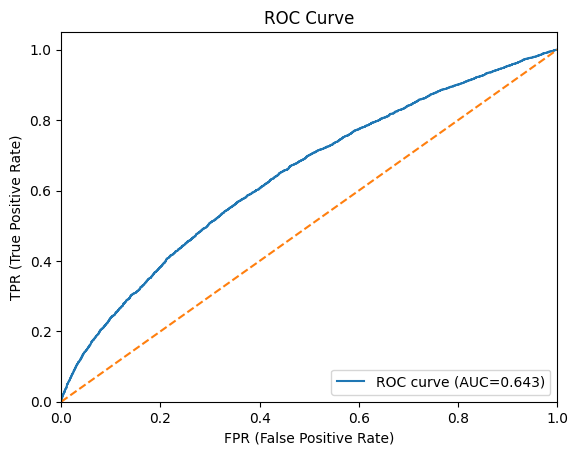

In [70]:
fpr, tpr, th = roc_curve(y_test, proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC={roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()